# Milestone Project 1: Food Vision Big

See the annotated version of this notebook on GitHub:
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check GPU

Google Colab offers free GPUs (thank you Google), however, not all of them are compatiable with mixed precision training.

Google Colab offers:

* K80 ( not compatible)

* P100 ( not_compatible)

* Tesla T4( compatible)


Knowing this, in order to use mixed precision training we need access to a Tesla T4.(from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0 + 




In [1]:
!nvidia-smi -L



GPU 0: Tesla K80 (UUID: GPU-8e0380e7-851e-bb10-0e9d-8cc5a8dddfb1)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small task required for our notebooks.

Rather than rewrite all of these , we can import a scritp and load them in from there.

The script we've got avalible can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [2]:
# Download helper functions script.

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-05-18 07:26:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-18 07:26:11 (53.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helpers functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download

If you want to get an overview of TensorFlow Datasets(TFDS), read the guide: https://www.tensorflow.org/api_docs/python/tf/data/Dataset


In [4]:
# Get TensorFlow Datasets

import tensorflow_datasets as tfds

In [5]:
# List all available datasets

datasets_list = tfds.list_builders() # get all available datasets in TFDS

print("food101" in datasets_list) # is our target dataset in the list of TFDS dataset


True


In [6]:
# load in the data (takes 5-6 minutes in google colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,# data gets returned in tuple format (data, label),
                                             with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteN0IMMY/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteN0IMMY/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class names


class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:

* Class names

* The shape of our input data(image tensors)

* The datatype of our input data

* What the labels look like (e.g are they one-hot encoded or are they label encoded)

* Do the labels match up with the class names?


In [9]:
# Take one sample of the traini data

train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [10]:

train_one_sample = train_data.take(1)# samples are in format (image_tensor, label)

In [11]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [12]:
# Output info about our training sample

for image, label in train_one_sample:
  print(f"""
  Image shape : {image.shape}

  Image datatype : {image.dtype}

  Target class from Food101 (tensor form): {label}

  Class name (str form): {class_names[label.numpy()]}
  
  
  """)


  Image shape : (512, 512, 3)

  Image datatype : <dtype: 'uint8'>

  Target class from Food101 (tensor form): 23

  Class name (str form): churros
  
  
  


In [13]:
# como la forma  de las clases  en el data set no esta en one-hot deberiamos usar sparse categorical

# What does our image tensor from TFDS's Food101 look like?
image


<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

In [14]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=9>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

PLot an image from TensorFlow Datasets

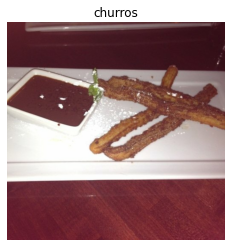

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)

plt.title(class_names[label.numpy()])## Add title to image to verify the label is associated with the right image

plt.axis(False);

## Create preprocessing functions for our data

Neural networks perfom best when data is in a certain way (e.g batched, normalized, etc).

However, not all data ( including data from TensorFlow Datasets) come like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `unit8` datatype

* Comprised of all different size tensors (different sized images)

* Not scaled (the pixel values are between 0 & 255)

What we know models like:

* Data in `float32` dtype ( or for mixed precision `float16` and `float32`)


* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1 ) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBx pretrained model from tf.keras.applications we don't need to rescale our data ( these architectures have rescaling built-in).

This means our functions needs to :

1. Reshape our images to all the same size

2. Convert the dtype of our image tensors from `unit8` to `float 32`.








In [16]:

#(image, label)

In [17]:
# Make a function for preprocessing images

def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` ->  `float32` and reshapes
  image to ( img_shape, img_shape, colour_channels)
  
  """
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [18]:
# Preprocess a singlee sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
# como la funcion me retorna una tupla, especifico qu quiero la imagen, "la cual esta en la primera posicion"



print(f"image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape:{preprocessed_img.shape},\nDatatype:{preprocessed_img.dtype}")

image before preprocessing:
 [[[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]

 [[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]]...,
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[93.       34.       40.      ]
  [94.       35.       41.      ]
  [95.       36.       42.      ]
  ...
  [55.       15.       24.      ]
  [52.       15.       23.      ]
  [52.       15.       23.      ]]

 [[93.92857  34.928574 40.928574]
  [93.07143  34.071426 40.071426]
  [94.       35.       41.      ]
  ...
  [55.       15.       24.      ]
  [54.       14.       23.      ]
  [52.       15.       23.      ]]]...,
Shape:(224, 224, 3),
Datatype:<dtype: 'float32'>


## Batch & prepare dataset

We're now going to make our data input pipeline run really fast.

For more resources on this, i'd  highly goind through the following guide: https://www.tensorflow.org/guide/data_performance

In [19]:
# Map preprocessing function to training (and parallelize)
# no olvidar pasar label a la funcion preprocess_img
# num_parallel_calls le dice a tensor flow que utilice todo el model de calculo que rquiera
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle train_data and turn it into batches and prefetch it (load it faster)
# buffer_size indica cuantos elementos quieres revolver por vez, pero hay que tener cuidado de la memora
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to tesst data

# prefetch me permite tener preparado el batch siguiento mientras realizo calculos sobre el primero
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
                          



In [20]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the  current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:

* TensorBoard callback to log training results( so we can visualize them later if need be) 

* ModelCheckpoint callback to save our model's progress after feature extraction


In [21]:
# Create tensorboard callback(import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callsback to save a model's progress during training

checkpoint_path = "model_checkpoints/cp.ckpt"

model_checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       monitor="val_accuracy",
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       verbose=0) # don't print wheter or not model is being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model perfomance.


In [22]:
# Turn on mixed precision training

from tensorflow.keras import mixed_precision

# politica de tipos de datos a usar para los modelos
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [23]:
!nvidia-smi

Tue May 18 07:35:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    57W / 149W |    127MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model



In [25]:
len(class_names)


101

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create base model

input_shape =(224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable =  False


# Create functional model

inputs = layers.Input(shape=input_shape, name="input_layer")

# Note: EfficientNetBx models have rescaling built-in but if your model doesn't you can have a layer like below

# x = preprocessing.Rescaling(1/255.)(x)

x = base_model(inputs, training=False) # make sure layers which should be in inference(not training) mode only stay like that

x = layers.GlobalAveragePooling2D()(x)

# separamos en 2 las outputs para setear el tipo de dato a float 32 y tener mejor estabilidad numerica
x = layers.Dense(len(class_names))(x)

# antes de la ultima capa los calculos se hacen con float16
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)


model = tf.keras.Model(inputs, outputs)

# Compile the model

# recordar que las labels no estan en hot encode
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


# Checking layer dtype policies(are we using mixed precision?)



In [28]:
# Check the dtype_policy attributes of layers in our model

for layer in model.layers:

  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

* `layer.name`: the human readable name of a particular layer

* `layer.trainable`: is the layer trainable or not?"(if`False`, the wrights are frozen)

* `layer.dtype`: the datatype a layer stores its variables in 

* `layer.dtype`: the data type policy a layer computes variables with

todas las variables seran guardadas en float 32, pero todas han sido calculadas en  mixed float 16



In [29]:
# check  the dtype_policy attributes of layers in the base model

for layer in model.layers[1].layers: # Check the layers of the base model (layer at index 1 of "model")
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

In [30]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## fit  the feature extraction model`

if our goal is to fine-tune a pretrained model, the general order of doing things is:

1. Build a feature extraction model(train a couple output layers with base layers frozen)

2. Fine-tune some of the frozen layers.



In [73]:
# Fit the feature extraction model with callabacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoints])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210518-100528
Epoch 1/3
2368/2368 [==============================] - 262s 107ms/step - loss: 1.0449 - accuracy: 0.7254 - val_loss: 1.0757 - val_accuracy: 0.7060
Epoch 2/3
2368/2368 [==============================] - 261s 106ms/step - loss: 0.9725 - accuracy: 0.7448 - val_loss: 1.0695 - val_accuracy: 0.7103
Epoch 3/3
2368/2368 [==============================] - 251s 104ms/step - loss: 0.9149 - accuracy: 0.7586 - val_loss: 1.0555 - val_accuracy: 0.7108


In [32]:
# Save our fine-tunning model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model2")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model2/assets


In [33]:
# load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model2")

In [34]:
# Evaluate loaded model and compare perfomance to pre-saved model

loaded_model_results = loaded_model.evaluate(test_data)


790/790 [==============================] - 86s 106ms/step - loss: 1.0811 - accuracy: 0.7081


In [35]:
# Evaluate model on whole test dataset
result_feature_extract_model = model.evaluate(test_data)


result_feature_extract_model

790/790 [==============================] - 77s 97ms/step - loss: 1.0811 - accuracy: 0.7081


[1.0810861587524414, 0.7081187963485718]

## Off to you...

We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, you're challange is to complete the TEMPLATE Version of 07

off the one we've built in this notebook

to beat the DeepFood paper.

In other words, you're going to create Food Vision Big !!

You can find the TEMPLATE Notebook here
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

And if you get stuck , you can refer to example version
(non-template):
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb


## Load and evaluate checkpoint weights

We can load in and evaluate or models checkpoint by:

1. Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extration model with reset weights.

2. Calling the load_weights() method on our cloned model passing itthe path to where our checkpointed weights are stored.

3. Calling evaluate() on the cloned model with loaded weights.


A reminder, checkpoints are helpfull for when you perfom an experiment such as fine-tuning your model. in the case you fine-tune your feature extraction model and find it doesn't offer any inprovements, you can always revert back to the checkpointed version of your model.




In [36]:
# Clone the model we created(this reset all weights)

cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [37]:
# Where are our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [38]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

Each time you make a change to your model(including loading weights), you have to recompile.



In [39]:
# Compile cloned_model ( with same parameter as original model)

cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [40]:
# Evaluate cloned model with loaded weight(should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 80s 97ms/step - loss: 1.0856 - accuracy: 0.7055



Our cloned model with loaded weights results should be very close to the feature extraction models results(if the cell below erros, something went wrong)

In [41]:
# Loaded checkpoint weights should retun very similar to checkpoint weights weights prior to saving
import numpy as np
assert np.isclose(result_feature_extract_model, results_cloned_model_with_loaded_weights).all()# check if all elements, in array are close



clonning the model preserve dtype_policy's of layers(but doesn't preserve weights) so if we wanted to continue fine-tunning with the cloned model, we could and it would still use the mixed precision dtype policy

In [42]:
# Check the layers in the base model and see what dtype policy they're using

for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <P

Save the whole model to file

We can also the whole model using the save(). method.

Since our model is quite large, you might want to save it to Google Drive(if you're using Google Colab) so you can load it in for use later.

**Note:** Saving to Google Drive requires mouunting Google  Drive (go to Files -> Mount Drive).

In [43]:

## Saving model to Google Drive

# Create save path to drive
import os
save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"

os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model

model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [44]:


# load model previosly saved above

loaded_saved_model = tf.keras.models.load_model(save_dir)

Loading SaveModel also retains all of the underlying layer dtype_policy(we want them to be "mixed_float16"

In [45]:
# Check the layers in the base model and see what dtype policy they're using

for layer in loaded_saved_model.layers[1].layers[:20]: # Check only the first 20 to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [46]:
# Check loaded model perfomance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)

790/790 [==============================] - 80s 97ms/step - loss: 1.0811 - accuracy: 0.7081


In [47]:

# The loaded model's results should equal (or at least be very close) to the model's results prior to saving

# Note: this will only work if you've instantiated results variables

import numpy as np

assert np.isclose(result_feature_extract_model, results_loaded_saved_model).all()

That's what we want!! or loaded model performing as it should.

> **Note:** We spent a fair bit of time making sure our model saved correctly bacause training on a lot of data can be time-consuming, so we want to make sure we don't have to continually train from scratch

## Preparing our model's layers for fine-tunning

Our feature-extration model is showing some great promise after three epochs. But sinse we've got so much data, it's probably worthwhile that we see what results we can get with fine-tunning(fine-tunning usually works best when you've got quite a large amount of data=.


Remember our goal of beating the DeepFoodpaper?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training

Do you think fine-tunning will get us there?

let's find out.

To start, let's load in our saved model.
> **Note:** It's worth remembering a tradicional workflow for fine-tunning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data(feature extraction). And then unfreeze a number or all of the layers in the base
model and continue training until the model stops improving

Like all good cooking shows, i've saved a model i prepared earlier (the feature extration model from above) to Google Storage.

We can download it to make sure we're using the same model going forward

In [48]:
# Download tge saved model from Google Storage

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2021-05-18 07:56:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.184.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.184.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  16.4MB/s    in 1.0s    

2021-05-18 07:56:12 (16.4 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [49]:
# Unzip the SavedModel downloaded from google storage
!mkdir downloaded_gs_model # create new dir to storage downloaded feature extraction model

!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [50]:
# Load and evaluate downloaded Gs model

loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [51]:
# Get a summary of our downloaded model

loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


And now let's make sure our loaded model  is perforgming as expected.

In [52]:

# How does the loaded model perfom?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)

results_loaded_gs_model 

790/790 [==============================] - 79s 97ms/step - loss: 1.0881 - accuracy: 0.7067


[1.0880919694900513, 0.7066534757614136]

Great, our loaded model is perfoming as expected

When we firts created our model, we froze all of the layers in the base model by setting `base_model.trainable=False` but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [53]:
# Are any of the layers in our model frozen?

for layer in loaded_gs_model.layers:
  layer.trainable=True # set all layer to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


alrigth, it seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model?
> **Question:** Which layer in the loaded model is our base model?

before saving the functional model to file, we created it with five layers(layer below are 0-indexed):

1. the input layer

2. the pre-trained base model layer(`tf.keras.applications.EfficientNetB0`)

3. The pooling layer


4. The fully-connected(dense)layer

5. The ouput softmax activation(with float 32 dtype)

Therefore to inspect our model layer, we can assces the `layers` attribute of the layer at index 1 in our model.

In [54]:
# Check the layers in the base model and see what dtype policy they're using

for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy
"mixed_policy16" is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model layers unfrozen.

>**Note:** If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.



A couple more callbacks

We're about to start fine-tunning a deep learning model with over 200 layers using over 100.000(75k + training, 25k + testing) images, which means our model's training time is probably going to be much longer than before.

> **Question:** How long does training take?

It could be a couple of hours or in the case of the DeeFoodpaper(the baseline we're triying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training

> **Question:** When do you stop training"?

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

luckily, there's a solution: the `EarlyStopping ` callback.


The EarlyStopping callback monitors a specified model perfomance metric(e.g val_loss) and when it stops improving for a specified number of epochs, automatically stops training.

Using the EarlyStopping callback combine with the ModelCheckpoint callback saving the best perfoming model automatically,

we could keep our model trainning for an unlimited number of epochs until it stops improving.


Let's set both of these up to monitor our model's val_loss.





In [55]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val_loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

#  Create ModelCheckpoint callback to save best model during fine-tunning
checkpoint_path ="fine_tune_checkpoints/"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")



Woohoo! fine-tuning callback ready

If you're planning on training large models, `the ModelCheckpoint` and `EarlyStopping` are two callbacks you'll want to become very familiar with

We're almost ready to start fine-tunning our model but there 's one more callback we're going to implement: `ReduceLROnPlateu` Remember how the learning rate is the most important model hyperparameter you can tune?(if not, treat this as a reminder).

Well, The ReduceLROnPlateu callback helps to tune learning rate for you


Like the ModelCheckpoint and EarlyStopping callbacks, the ReduceLROnPlateu callback monitors as specified metric and when that metrics stops improving, it reduces the learning rate by a specified factor(e.g divides the learning rate by 10).

> Question: Why lower the learning rate?

Imagine having coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin


The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance(also called **convergence**), we want the amount it learns to be less and less


To do this we'll create loss stop improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (eg. 0.001 to 0.0002)


and to make sure the learning rate doesn't get too low( and potentially result in our models learning nothing), we'll set the minimum learning rate to 1e-7

In [57]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

Learning rate reduction ready to go !

Now before we start traininig, we've got to recompile our model

We'll use sparse categorical crossentropy as the loss and since we're fine-tunning, we'll use a 10x lower learning rate than the Adam optimizer default(1e-4 instead of 1e-3)

In [58]:
# Compile the model

loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

okay. model compiled.

Now let's fit it on all of the data.

We'll set it up to run for 100. epochs.

Since we're going to be using the `EarlyStopping` callback, it might stop before reaching 100 epochs.


> **Note:** Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with unoptimized data pipelines and without mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, the code we've written above will ensure it runs much faster (more like 4-5 minutes per epoch).

In [59]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20210518-080106
Epoch 1/100
2368/2368 [==============================] - 1151s 473ms/step - loss: 0.9747 - accuracy: 0.7362 - val_loss: 0.7900 - val_accuracy: 0.7850
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/100
2368/2368 [==============================] - 1104s 465ms/step - loss: 0.5794 - accuracy: 0.8379 - val_loss: 0.7677 - val_accuracy: 0.7892
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/100
2368/2368 [==============================] - 1104s 465ms/step - loss: 0.3337 - accuracy: 0.9060 - val_loss: 0.9065 - val_accuracy: 0.7757
Epoch 4/100
2368/2368 [==============================] - 1101s 464ms/step - loss: 0.1694 - accuracy: 0.9510 - val_loss: 0.9830 - val_accuracy: 0.7836

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 1102s 465ms/step - loss: 0.0499 - accuracy: 0.9881 - val_loss: 1.0615 - val_accuracy: 0.8040


In [61]:
# # Save odel to Google Drive (optional)
loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


In [62]:
# Evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data) 
results_loaded_gs_model_fine_tuned

790/790 [==============================] - 77s 97ms/step - loss: 1.0617 - accuracy: 0.7975


[1.061668038368225, 0.7974653244018555]

## Download fine-tuned model from Google Storage

As mentioned before, training models can take a significant amount of time.

And again, like any good cooking show, here's something we prepared earlier...

It's a fine-tuned model exactly like the one we trained above but it's saved to Google Storage so it can be accessed, imported and evaluated.

In [63]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

In [64]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2021-05-18 09:45:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M  49.3MB/s    in 0.9s    

2021-05-18 09:45:19 (49.3 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



In [65]:


# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model



Archive:  /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


In [66]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [67]:


# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [68]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 79s 97ms/step - loss: 0.9072 - accuracy: 0.8016


[0.9072333574295044, 0.8016237616539001]

## *View* training results on TensorBoard

Since we tracked our model's fine-tuning training logs using the TensorBoard callback, let's upload them and inspect them on TensorBoard.dev.
  


In [74]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

2021-05-18 10:19:31.769181: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/nnqCp7mkTZe2ig7Lt0S1kQ/

[2021-05-18T10:19:37] Started scanning logdir.
[2021-05-18T10:19:41] Total uploaded: 32 scalars, 0 tensors, 2 binary objects (2.0 MB)
[2021-05-18T10:19:41] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/nnqCp7mkTZe2ig7Lt0S1kQ/


In [72]:
 #View past TensorBoard experiments
!tensorboard dev list

2021-05-18 10:01:06.863219: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/9kq0FOHNQkizpQdsq3pbVg/
	Name                 [No Name]
	Description          [No Description]
	Id                   9kq0FOHNQkizpQdsq3pbVg
	Created              2021-05-18 09:58:36 (2 minutes ago)
	Updated              2021-05-18 09:58:38 (2 minutes ago)
	Runs                 2
	Tags                 3
	Scalars              20
	Tensor bytes         0
	Binary object bytes  1271569
Total: 1 experiment(s)


In [89]:
# load in the data (takes 5-6 minutes in google colab)
(train_data_sort, test_data_sort), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,# data gets returned in tuple format (data, label),
                                             with_info = True)

In [91]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [92]:
# Get the class names


class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [93]:
# prefetch me permite tener preparado el batch siguiento mientras realizo calculos sobre el primero
test_data_sort = test_data_sort.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
                          


In [94]:
# Make predictions with model

preds_probs = model.predict(test_data_sort, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 74s 94ms/step


In [95]:
preds_probs

array([[2.1553447e-03, 6.5714667e-06, 1.3720842e-06, ..., 8.0539339e-04,
        4.8945082e-04, 6.4105406e-02],
       [1.2947497e-04, 1.5373238e-05, 1.6527787e-04, ..., 6.6000306e-05,
        2.1832301e-03, 8.1340484e-05],
       [2.0144760e-05, 4.6889458e-05, 3.4279943e-05, ..., 1.0686763e-06,
        5.8091897e-05, 2.1461733e-06],
       ...,
       [8.2689367e-02, 1.6598689e-04, 1.2140235e-06, ..., 4.5913195e-05,
        2.0496645e-04, 3.6053825e-02],
       [1.8683643e-06, 1.5259488e-08, 2.0587150e-07, ..., 9.8715267e-09,
        4.7929575e-08, 3.0834217e-06],
       [5.6554088e-03, 3.9798320e-05, 4.2454255e-04, ..., 2.2334835e-02,
        1.3360817e-03, 5.0910423e-04]], dtype=float32)

In [76]:
len(test_data)


790

In [77]:
# How many predictions are there?
len(preds_probs)

25250

In [78]:
# what' the shape of our predictions?
preds_probs.shape

(25250, 101)

In [79]:
# Let' see what the first 10 predictions look like
preds_probs[:100]

array([[5.7589989e-07, 1.0425087e-08, 9.5838704e-10, ..., 1.1721240e-08,
        2.3546256e-06, 2.9010348e-08],
       [4.6506437e-04, 9.0685457e-01, 5.9715449e-04, ..., 9.3874252e-05,
        2.0905307e-05, 2.2037320e-05],
       [5.0106049e-08, 4.7465201e-06, 1.4355622e-08, ..., 2.1553558e-07,
        4.9791702e-06, 2.2147738e-08],
       ...,
       [4.2257266e-06, 5.9476019e-06, 3.9994815e-05, ..., 2.6616286e-05,
        1.6548182e-06, 1.2130579e-06],
       [3.8048463e-05, 3.4498157e-07, 6.4586688e-06, ..., 2.1343254e-05,
        5.2876669e-05, 2.3946468e-06],
       [8.4936140e-08, 6.8525452e-07, 1.5203035e-06, ..., 2.7245334e-10,
        5.8604172e-08, 2.3543406e-07]], dtype=float32)

In [80]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])


(array([5.7589989e-07, 1.0425087e-08, 9.5838704e-10, 3.3450991e-09,
        1.5621704e-07, 3.1123562e-08, 9.5121273e-08, 3.8652543e-09,
        4.8205116e-08, 6.2739276e-09, 2.4569056e-09, 3.4726025e-07,
        5.3342269e-10, 8.3780428e-08, 2.4813867e-08, 8.9721300e-07,
        2.4813867e-08, 2.4239052e-08, 5.9980853e-06, 7.1221273e-10,
        7.1973904e-05, 2.3999911e-09, 1.5588896e-08, 3.2242022e-07,
        8.5909257e-10, 2.3012042e-06, 3.6960145e-08, 2.1307496e-08,
        6.0335776e-09, 5.4296323e-09, 1.5591223e-07, 3.0937113e-09,
        6.3321481e-06, 9.9985552e-01, 2.7089440e-09, 5.0329089e-07,
        4.4932108e-08, 3.2242022e-07, 4.9735309e-08, 1.6724444e-08,
        2.1631600e-05, 1.3568321e-09, 5.0609734e-09, 2.3661510e-06,
        1.4223724e-07, 1.4618021e-07, 2.5402310e-08, 5.0427479e-07,
        2.8037064e-06, 3.1519071e-06, 3.6893533e-07, 1.9086970e-06,
        6.2391365e-07, 1.6992889e-06, 1.4781502e-11, 5.4936353e-09,
        5.9866241e-09, 8.6115762e-07, 2.9062726e

In [81]:
# We get one prediction probability per class (in our case there's a 101 prediction probabilities)

print(f"Number of prediction probabilities for sample 0:{len(preds_probs[0])} ")
print(f"What prediction probability sample 0 looks like:\n{preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")


Number of prediction probabilities for sample 0:101 
What prediction probability sample 0 looks like:
[5.7589989e-07 1.0425087e-08 9.5838704e-10 3.3450991e-09 1.5621704e-07
 3.1123562e-08 9.5121273e-08 3.8652543e-09 4.8205116e-08 6.2739276e-09
 2.4569056e-09 3.4726025e-07 5.3342269e-10 8.3780428e-08 2.4813867e-08
 8.9721300e-07 2.4813867e-08 2.4239052e-08 5.9980853e-06 7.1221273e-10
 7.1973904e-05 2.3999911e-09 1.5588896e-08 3.2242022e-07 8.5909257e-10
 2.3012042e-06 3.6960145e-08 2.1307496e-08 6.0335776e-09 5.4296323e-09
 1.5591223e-07 3.0937113e-09 6.3321481e-06 9.9985552e-01 2.7089440e-09
 5.0329089e-07 4.4932108e-08 3.2242022e-07 4.9735309e-08 1.6724444e-08
 2.1631600e-05 1.3568321e-09 5.0609734e-09 2.3661510e-06 1.4223724e-07
 1.4618021e-07 2.5402310e-08 5.0427479e-07 2.8037064e-06 3.1519071e-06
 3.6893533e-07 1.9086970e-06 6.2391365e-07 1.6992889e-06 1.4781502e-11
 5.4936353e-09 5.9866241e-09 8.6115762e-07 2.9062726e-09 2.1604035e-07
 3.5257086e-10 1.2773083e-08 3.0182364e-06 2.4

In [96]:
# Get the pred classes of each label
# esto me devuelve un vector columna con la posicion de la maxima probabilidad para cada registro
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3, 94])

In [83]:
# How many pred classes do we have?

len(pred_classes)

25250

In [84]:
# actualmente el test_data esta envuelto como un tensorflow batch dataset 
test_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [109]:
# To get our labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data_sort.unbatch():
  y_labels.append(labels.numpy()) # currently test labels look like: [0, 0, 0, 1,...0, 0](one hot encode), we want the index value where the "1" occurs

y_labels[:10] # look at the first 10

# podemos comparar debido a que cuando cargamos el test data desactivamos el shuffle, ahora podemos comparar manzanas con manzanas

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [107]:

test_data.unbatch()

<_UnbatchDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

In [105]:
test_data.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files>

In [102]:

y_labels[-1]

0

In [86]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions
One way to check that our model's predictions array is in the same order our test labels array to find the accuracy score

In [110]:
# Let's try scikit-learn's accuracy score function and see what it comes up with

from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.7126336633663366

In [111]:
from helper_functions import make_confusion_matrix

In [112]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [113]:
import itertools

import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import confusion_matrix


# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


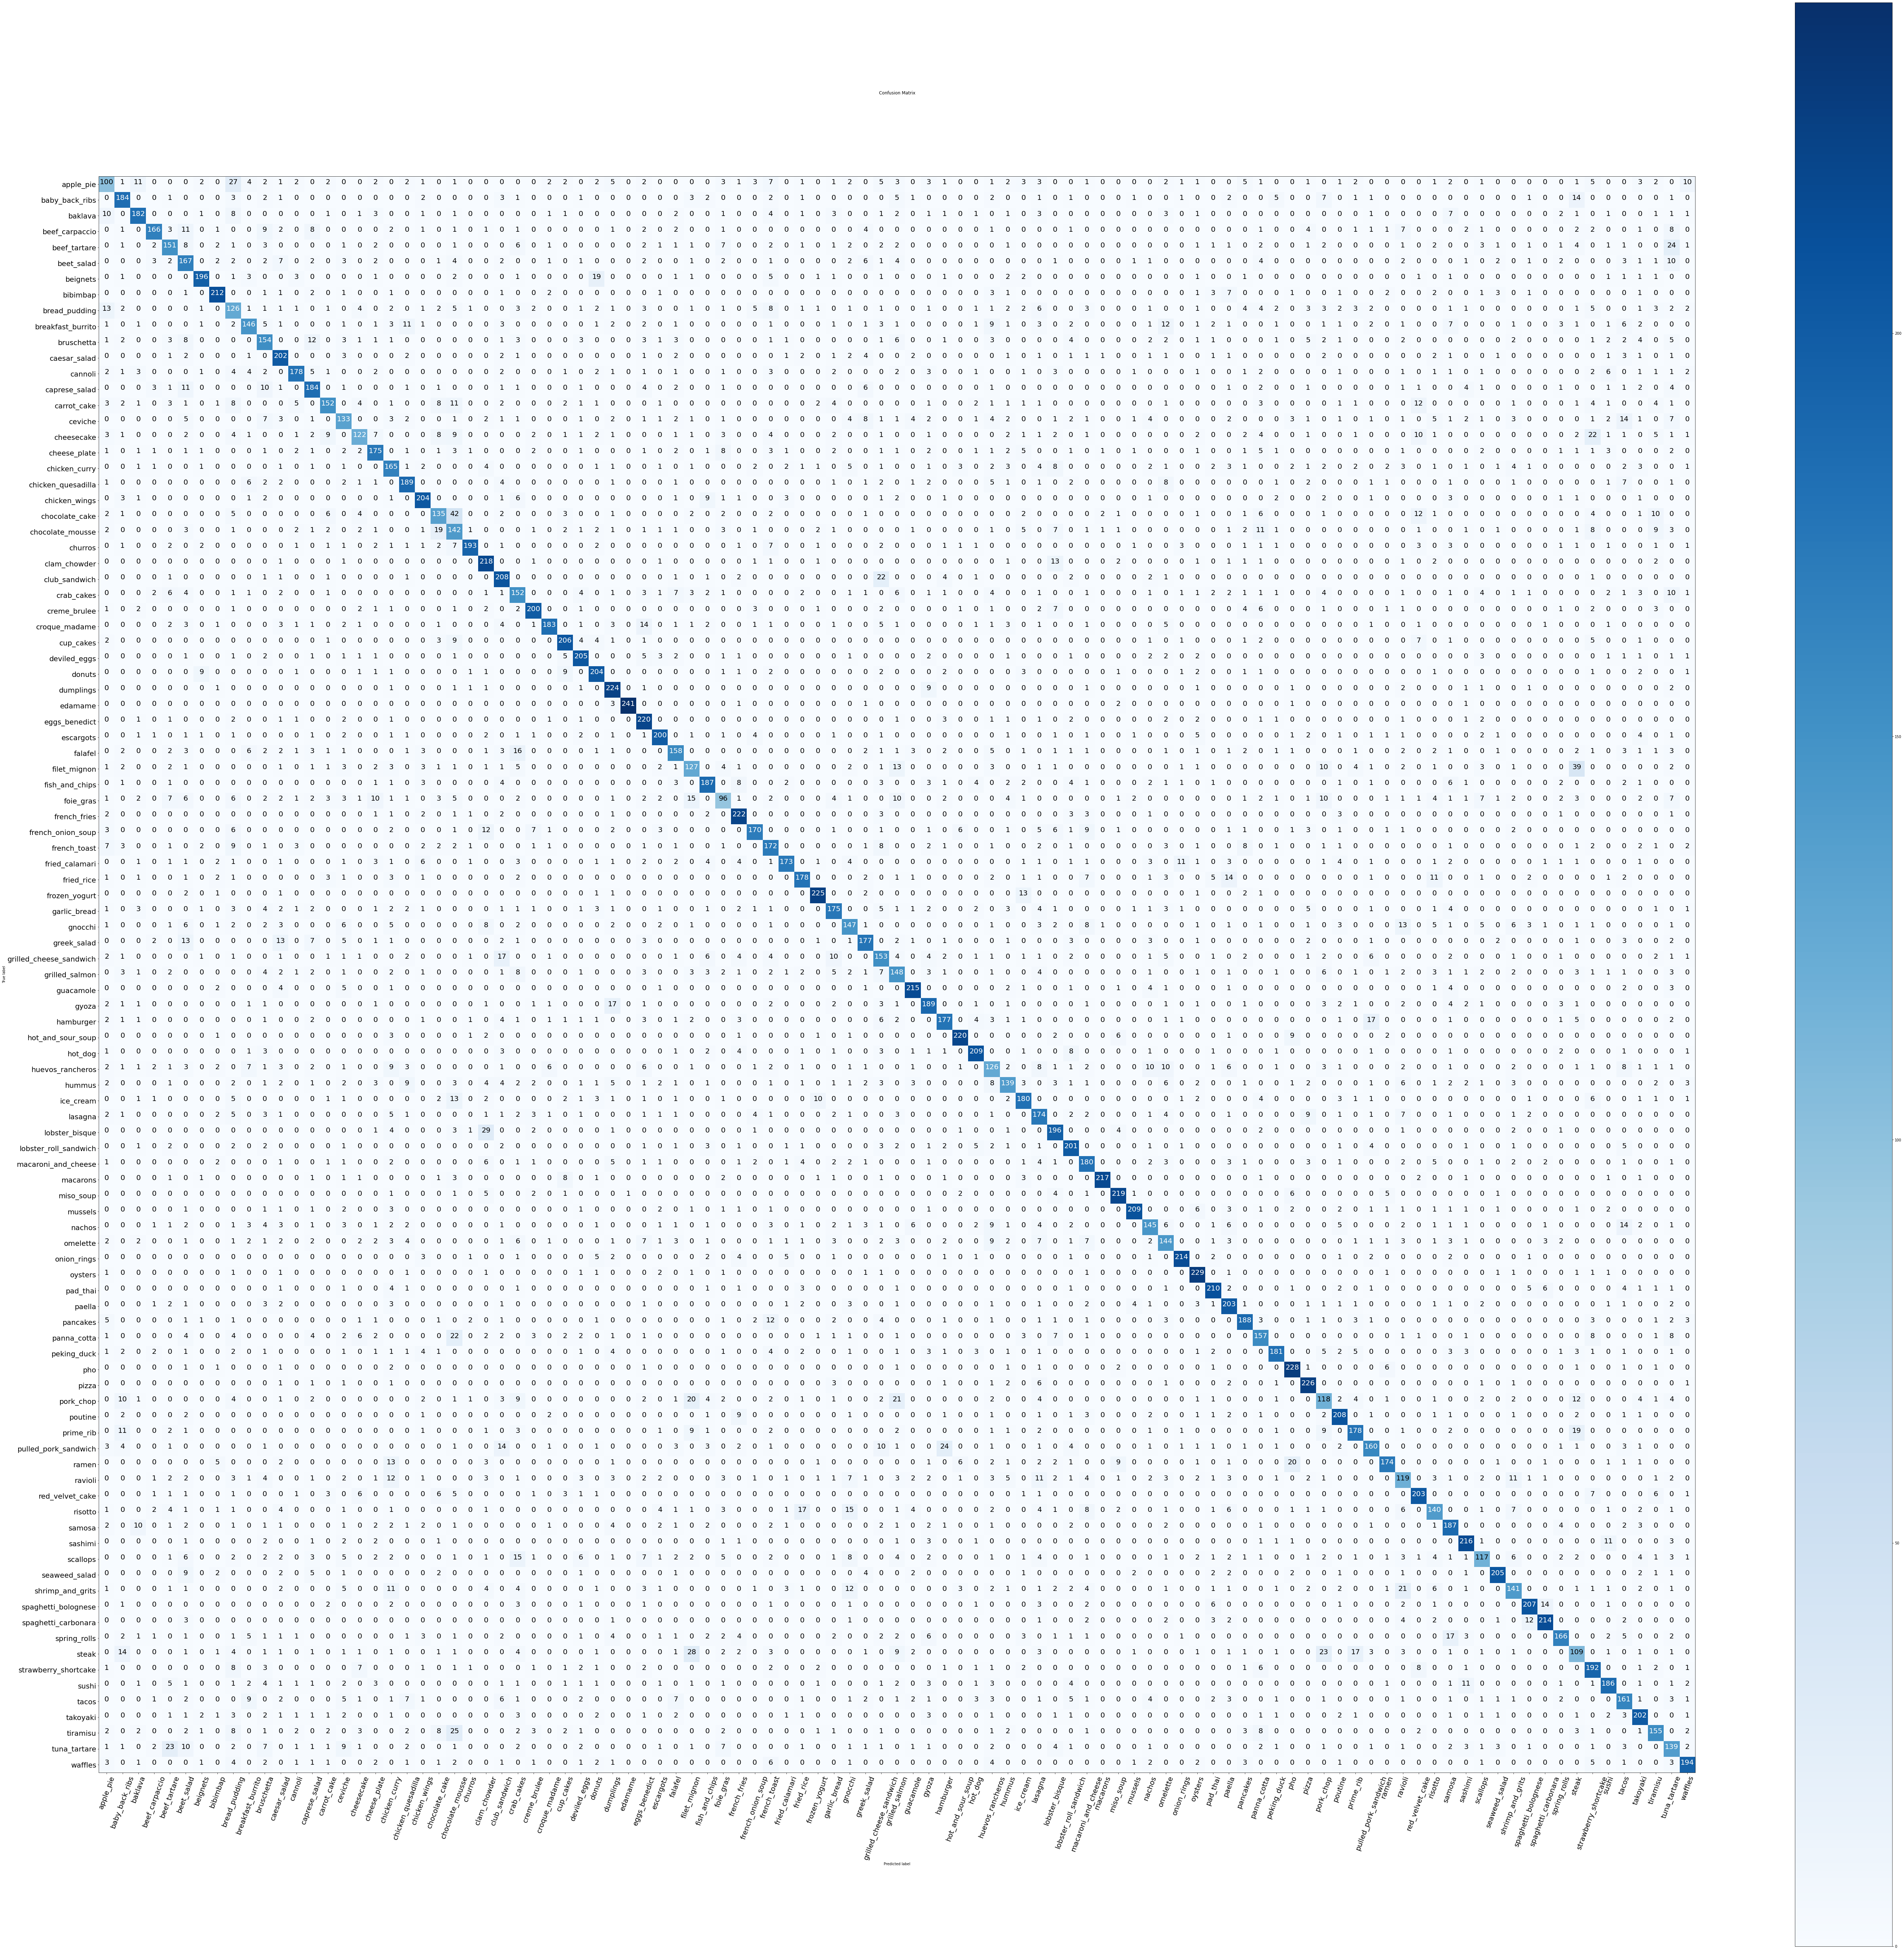

In [114]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report¶
Scikit-learn has a helpful function for acquiring many different classification metrics per class ( e.g precision, recall and F1) called classification_report, let's try it out.

In [115]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.51      0.40      0.45       250
           1       0.70      0.74      0.72       250
           2       0.77      0.73      0.75       250
           3       0.85      0.66      0.74       250
           4       0.62      0.60      0.61       250
           5       0.52      0.67      0.58       250
           6       0.87      0.78      0.82       250
           7       0.86      0.85      0.85       250
           8       0.43      0.50      0.46       250
           9       0.71      0.58      0.64       250
          10       0.56      0.62      0.59       250
          11       0.67      0.81      0.73       250
          12       0.84      0.71      0.77       250
          13       0.68      0.74      0.71       250
          14       0.76      0.61      0.68       250
          15       0.55      0.53      0.54       250
          16       0.69      0.49      0.57       250
          17       0.71    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [116]:
#  Get a dictironary of the classification report

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.44742729306487694,
  'precision': 0.5076142131979695,
  'recall': 0.4,
  'support': 250},
 '1': {'f1-score': 0.7159533073929961,
  'precision': 0.696969696969697,
  'recall': 0.736,
  'support': 250},
 '10': {'f1-score': 0.5877862595419847,
  'precision': 0.5620437956204379,
  'recall': 0.616,
  'support': 250},
 '100': {'f1-score': 0.7918367346938776,
  'precision': 0.8083333333333333,
  'recall': 0.776,
  'support': 250},
 '11': {'f1-score': 0.7318840579710146,
  'precision': 0.6688741721854304,
  'recall': 0.808,
  'support': 250},
 '12': {'f1-score': 0.7688984881209504,
  'precision': 0.8356807511737089,
  'recall': 0.712,
  'support': 250},
 '13': {'f1-score': 0.7063339731285989,
  'precision': 0.6789667896678967,
  'recall': 0.736,
  'support': 250},
 '14': {'f1-score': 0.6770601336302896,
  'precision': 0.7638190954773869,
  'recall': 0.608,
  'support': 250},
 '15': {'f1-score': 0.5428571428571428,
  'precision': 0.5541666666666667,
  'recall': 0.532,
  'su

In [117]:
class_names[70]

'pad_thai'

In [118]:
classification_report_dict["99"]["f1-score"]

0.5129151291512916

In [119]:
# Create empty dictionary

class_f1_scores  = {}

# Loop through classification report dictionary items

for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key,
    break
  else:
    # Addclass_names and f1=scores to new dictionary
    class_f1_scores[class_names[int(k)]]= v["f1-score"]

class_f1_scores


{'apple_pie': 0.44742729306487694,
 'baby_back_ribs': 0.7159533073929961,
 'baklava': 0.748971193415638,
 'beef_carpaccio': 0.7443946188340808,
 'beef_tartare': 0.611336032388664,
 'beet_salad': 0.5818815331010453,
 'beignets': 0.8235294117647058,
 'bibimbap': 0.8548387096774194,
 'bread_pudding': 0.463235294117647,
 'breakfast_burrito': 0.6417582417582418,
 'bruschetta': 0.5877862595419847,
 'caesar_salad': 0.7318840579710146,
 'cannoli': 0.7688984881209504,
 'caprese_salad': 0.7063339731285989,
 'carrot_cake': 0.6770601336302896,
 'ceviche': 0.5428571428571428,
 'cheese_plate': 0.7056451612903226,
 'cheesecake': 0.5714285714285714,
 'chicken_curry': 0.6032906764168191,
 'chicken_quesadilla': 0.75,
 'chicken_wings': 0.8047337278106509,
 'chocolate_cake': 0.5856832971800435,
 'chocolate_mousse': 0.4838160136286201,
 'churros': 0.8391304347826086,
 'clam_chowder': 0.7649122807017543,
 'club_sandwich': 0.7323943661971831,
 'crab_cakes': 0.5725047080979283,
 'creme_brulee': 0.816326530612

In [120]:
# Turn f1-scores into dataframe for visualization
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())
                          
                          }).sort_values("f1-score", ascending=False)

In [121]:
f1_scores[:10]

,class_names,f1-score
33,edamame,0.979675
63,macarons,0.917548
45,frozen_yogurt,0.889328
54,hot_and_sour_soup,0.888889
65,mussels,0.874477
64,miso_soup,0.870775
68,onion_rings,0.869919
91,spaghetti_carbonara,0.864646
75,pho,0.857143
88,seaweed_salad,0.855950


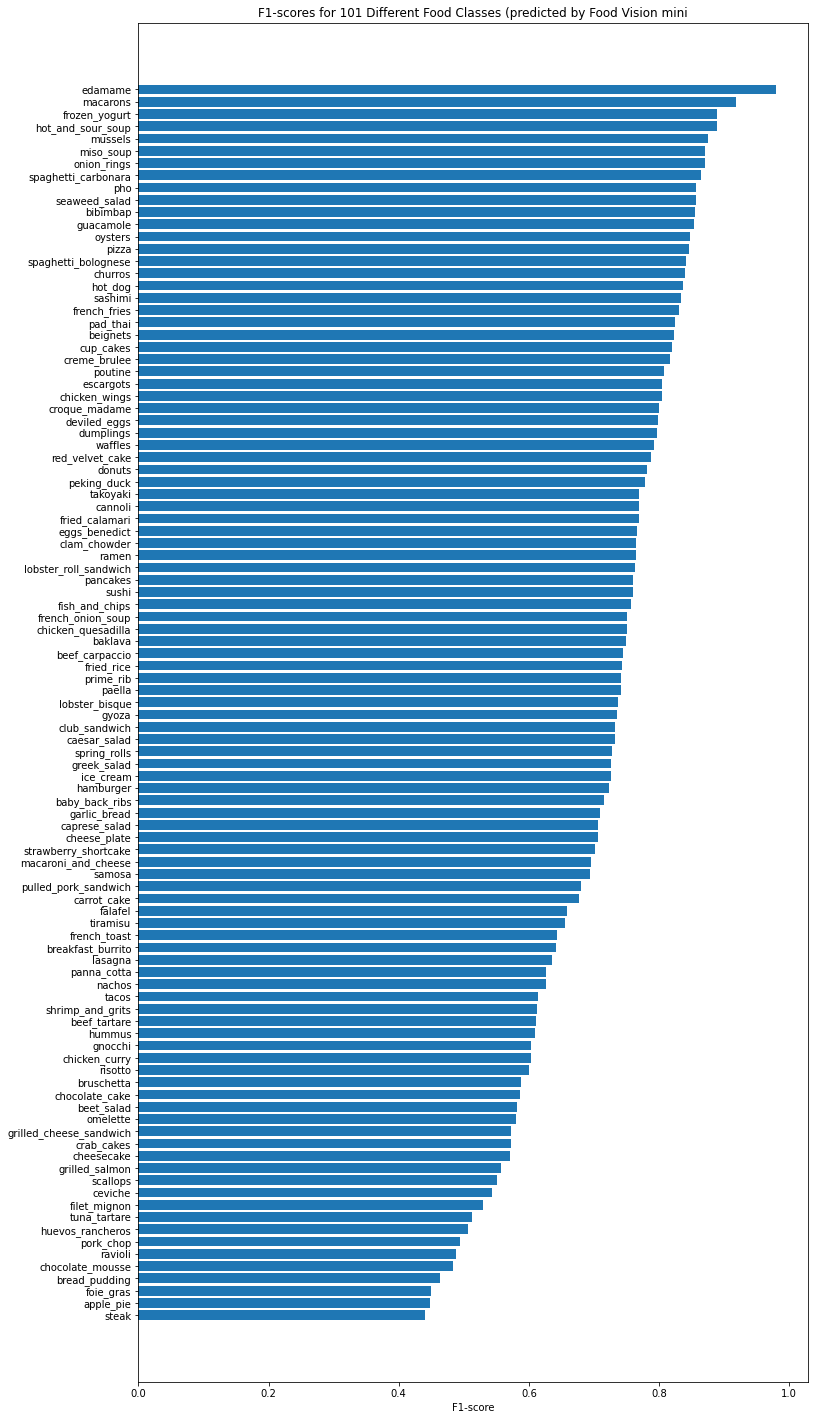

In [122]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values

ax.set_yticks(range(len(f1_scores)))

ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")

ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini")

ax.invert_yaxis(); # reverse the order of our plot

# CHallenge: add values to the end of each bar of what the actual f1-score is (hint: use the "autolabel function" from here":https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)


In [123]:
pred_classes

array([29, 81, 91, ..., 76, 31, 22])

## Visualizing predictions on test images
Now, this is the real test, how does our model go on food images not even in our test dataset(images of our own, we'll see this later on).

* To visualize our model's predictions on our own images, we need a function to load and preprocess images', specifically it will need to:

* Read in a target image filepath using tf.io.read_file() "inputs, outputs"

* Turn the image into a Tensor using tf.io.decode_image()

* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()

* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [124]:
# Create a function to load and prepare images

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape ( img_shape, img_shape, color_channels=3).

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor

  img = tf.io.decode_image(img, channels=3)


  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no

  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.

  else:
    return img # don't need to rescale images for EfficientNet

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:

1. Load a few random images from the test dataset

2. Make predictions on the loeaded images

3. Plot the original image(s) along with the model's predictions, predictions probability and truth label

In [126]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [127]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):

  # Choose  random image(s) from a random class(es)

  class_name= random.choice(class_names)

  filename = random.choice(os.listdir(test_dir + "/" + class_name))

  filepath = test_dir + class_name + "/" + filename

  # print(filepath)

  # Load the image and make predictions

  img = load_and_prep_image(filepath, scale=False)

  # recordar que debemos transformar las imagenes al formato con el cual fue entrado el modelo (osea expandir en este caso)
  #print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  #print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array

  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list

  #print(pred_prob)
  #print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i + 1)
  plt.imshow(img/255.)
  if class_name == pred_class:# if predicted class matches thruth class, mkae text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f} ", c=title_color)
  plt.axis(False);

NameError: ignored

<Figure size 1224x720 with 0 Axes>

##Finding the most wrong predictions
To find out where our model is most wrong, let's write some code to find out the following:

Get all of the image file paths in the test dataset using list_files() method

Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.

Use our DataFrame to find all the wrong predictions ( where the ground truth label doesn't match the prediction).

Sort the DataFrame based on wrong predictions(have the highest prediction probability predictions at the top).

Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [128]:
#1. Get all of the image file paths in the test dataset

filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]


InvalidArgumentError: ignored

## Test out the big dog model our own custom images

In [130]:
# Import series of helpers functions for the notebook
from helper_functions import unzip_data

In [131]:
# get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-05-18 12:06:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 64.233.184.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  19.6MB/s    in 0.6s    

2021-05-18 12:06:17 (19.6 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [132]:
# Get the custom food images filepaths

# comprension de listas
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]

custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg']

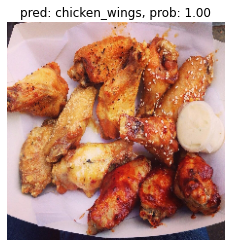

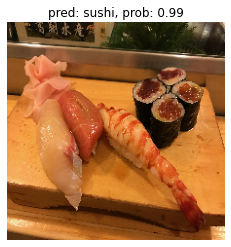

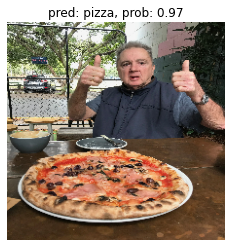

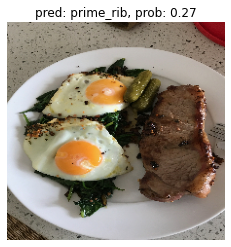

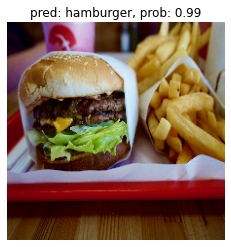

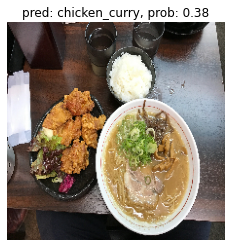

In [133]:
# Make prediction on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0))# make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highest prediction probability

  # Plot the appropiate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)